# Computational Neuroscience - Assignment 1:

## Malaik Kabir (24100156)

In this assignment I have used the following models to simulate a neuron:

1) The leaky Integrate and Fire Model <br><br>
2) The Hodgkin - Huxley Model

## 1) The Leaky Integrate and Fire Model:

The leaky integrate and fire model is a computationally inexpensive model that simulates a neuron as a circuit with a capacitor and a resistor. The resistor serves as a sort of "Leak" channel, energy is dissipated out of the neuron through this leak channel. The capacitor part of the circuit simulates the Nernst Potential across the membrane: charge distributed on the two plates of the capacitor behaves in a similar manner to the charge distributed across the membrane. The differential equation for the sub-threshold behaviour of the Leaky Integrate Model is written as:

$$C\frac{dV}{dt} = - g_L(V-V_L) + I$$

Where $g_L$ is the conductance of the leaky resistor (i.e $\frac{1}{R_L})$,$V_L$ is the voltage acros the leaky resistor, $I$ is the current injected, $V$ is the total voltage across the neuron membrane and $C$ is its capacitance.

Since the LIF model is supposed to model a neuron, it also needs to take into account its spiking behaviour. However, in the case of this model, the behaviour is inserted in a very ad-hoc fashion. That is, the spiking behaviour is not built into the differential equations, but instead is added as an afterthought, roughly as follows:

$$\text{if }V> V_{th} : V = V_{reset} $$

Which basically means that if the voltage exceeds some pre-determined threshold value $V_{th}$ it should be reset to some other value $V_{reset}$ generally a lot smaller than the threshold voltage. This simulates the spiking behaviour.

## Coding up the Leaky Integrate and Fire model:

In order to model the subthreshold behaviour numerically, we solve the differential equation using the Euler method. The Euler method splits the real line (in this case the time axis) into a discrete set of intervals ($\Delta t$). Starting from the first of these intervals, it then "estimates" the function value in the next interval using the gradient of the function computed through the scheme given in the differential equation.

For example in order to predict $V_{n+1}$ from $V_{n}$ we use:

$$\Delta V = \frac{- g_L(V-V_L) + I}{C}\Delta t$$

So that we can say:

$$V_{n+1} = V_{n} + \Delta V$$

Beyond the threshold voltage $V_{th}$, "if statements" are implemented to change the voltage to the reset value.

Before coding up the equation, we first bring it into a more suitable form: one that explicitly shows the time constant $\tau$ of the equation. Such a time constant explicitly dictates how long it takes for the voltage to change appreciably. To do so, we divide the equation by $g_L$ throughout:

$$\frac{C}{g_L}\frac{dV}{dt} = -(V-V_L) + \frac{I}{g_L}$$

Where we now define $\frac{C}{g_L} = \tau$ and rearrange the equation to get:

$$\frac{dV}{dt} = \bigg(-(V-V_L) + \frac{I}{g_L}\bigg)\cdot\frac{1}{\tau}$$

## Keeping all of the Parameters in one place:

We first run a cell that generates a dictionary with all of our parameters in one place. This reduces the hassle of trying to figure out where to change a particular value in order to run the simulation for that value:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def InitializeParameters():
    
    #Defines a dictionary called parameters
    parameters = {}
    
    #The threshold voltage
    parameters['Vthreshold'] = -55.
    
    #The reset voltage
    parameters['Vreset'] = -75.
    
    #The initial voltage
    parameters['Vinitial'] = -65.
    
    #The voltage across the leak resistor
    parameters['Vleak'] = -75.
    
    #The time constant Tau
    parameters['Tau'] = 10.
    
    #The conductance of the leak resistor: g_L
    parameters['Conductance'] = 10.
    
    #Refractory period after a spike
    parameters['Refractory'] = 2.
    
    #Duration over which the simulation runs
    parameters['Duration'] = 400.
    
    #Time step dt between the intervals
    parameters['Timestep'] = 0.1
    
    #All of time values stored in a numpy array
    parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])
    
    #Constant current applied
    parameters['Current'] = 250
    
    return parameters

With the parameter dictionary defined we now turn towards actually defining a function that runs the Leaky Integrate and Fire model.

## Running the Leaky Integrate and Fire Model with a constant input Current:

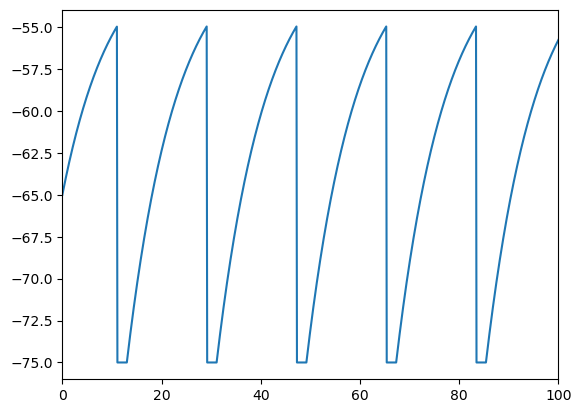

In [73]:
#The following function is used to calculate Delta V when updating the Voltage in the function LeakyIntegrate

def DeltaCalculator(V,I,parameters):
    Vth = parameters['Vthreshold']
    VL  = parameters['Vleak']
    Tau = parameters['Tau']
    dt  = parameters['Timestep']
    gL  = parameters['Conductance']
    
    DeltaV = (-(V - VL) + I/gL) * dt/Tau
    
    return DeltaV

def LeakyIntegrate(parameters, currenttype = 'constant', freq = 1 , sig = 1):
    I   = parameters['Current']
    Vth = parameters['Vthreshold']
    Vr  = parameters['Vreset']
    Vin = parameters['Vinitial']
    VL  = parameters['Vleak']
    Tau = parameters['Tau']
    tr  = parameters['Refractory']
    T   = parameters['Duration']
    dt  = parameters['Timestep']
    timegrid = parameters['Timegrid']
    
    size = timegrid.size
    Voltage = np.zeros(size)

    Voltage[0] = Vin
    
    if currenttype == 'constant':
        Current = I*np.ones(size)
    
    elif currenttype == 'sine':
        Current = I*np.sin(freq*timegrid)
        
    elif currenttype == 'GWN':
        np.random.seed()
        Current = sig*np.random.randn(size)/np.sqrt(dt/1000.) + I
    
    SpikeList = []
    RefractoryTimeLeft = 0
    
    
    for i in range(size-1):

        #The first if statement checks if the refractory time has elapsed
        
        if RefractoryTimeLeft > 0:
            RefractoryTimeLeft = RefractoryTimeLeft - 1
            Voltage[i] = Vr
        
        #This if statement checks if the threshold voltage has been reached
        
        elif Voltage[i] > Vth:         
            SpikeList.append(i)
            RefractoryTimeLeft = tr/dt
            
        Voltage[i+1] = Voltage[i] + DeltaCalculator(Voltage[i],Current[i],parameters)
        
    SpikeArray = np.array(SpikeList)*dt
        
    return Voltage,SpikeArray,Current

parameters = InitializeParameters()
Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]

plt.plot(parameters['Timegrid'],Voltage)
plt.xlim(0,100)
plt.show()

What we have plotted above is the response of the LIF model to a constant current of 250 units (our function takes in the "type" of the current as one of its arguments, this will turn out to be useful as we test different types of input currents). It can be clearly seen that the sub-threshold behaviour is that the input gets integrated starting from an initial voltage of -65 (the curved portion shows exactly this integration). This happens until the voltage reaches the threshold value, at which point the if statement kicks in, resetting the voltage to $V_{reset}$. What follows is a period of refractoriness (characterized by the horizontal lines separating the points where the voltage stays at $V_{reset}$. Once the refractory period has elapsed, integration starts again.

However, this isn't always what will happen. In fact if you plot the model for an input current of less than 200, there isn't enough charge to counter the leaky resistance. This results in so spiking at all. Here we plot that:

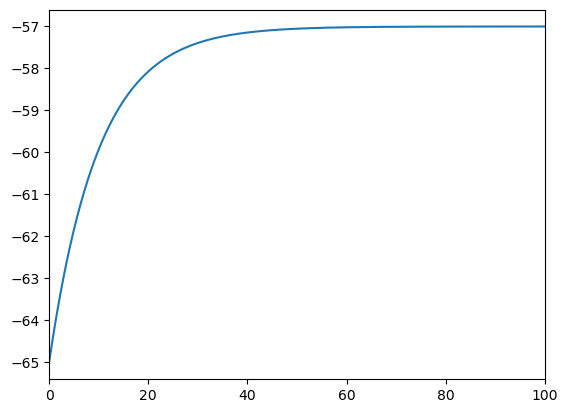

In [39]:
parameters = InitializeParameters()
parameters['Current'] = 180
Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]

plt.plot(parameters['Timegrid'],Voltage)
plt.xlim(0,100)
plt.show()

The output voltage plateaus to a certain value below the threshold. This is the farthest it can go. This is essentially because the voltage depends on the charge accumulated on the membrane. If there isn't sufficient charge in the current, the neuron will never spike.

## Running the Leaky Integrate and Fire Model with a sinusoidal Input current:

We now turn towards some more exotic currents. Lets try applying a sinusoidal input current. We only need to modify the current in our LeakyIntegrate function:

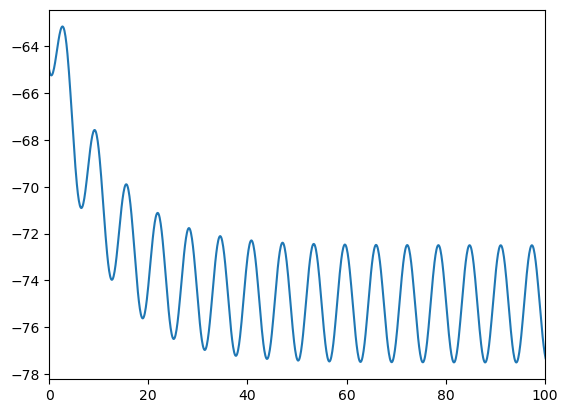

In [40]:
parameters = InitializeParameters()
parameters['Current'] = 250
Voltage = LeakyIntegrate(parameters,'sine')[0]
Spikes = LeakyIntegrate(parameters,'sine')[1]

plt.plot(parameters['Timegrid'],Voltage)
plt.xlim(0,100)
plt.show()

As it stands, this response to the current is quite un-interesting. Why? For one, the output voltage never reaches its threshold value, which means there is no spiking. In fact, we can numerically show this by printing out our spike array, which we just extracted after running our LIF for the sinusoidal input:

In [4]:
print(Spikes)

[]


Alas! It is empty. But why is this so? Well, one could argue that as it stands, the sinusoidal current has too big of a frequency for the voltage output to be integrated appreciably enough such that it reaches the threshold voltage. What happens instead is that the output becomes a sine wave whose mean value decays until it reaches some static value. This is because we started the current at an initial value of -65.

To test our hypothesis that the output is indeed not spiking because of the large frequency we now run the LIF model again, only this time with a prefactor of 0.02 next to the argument of the sine function (this serves to decrease the frequency, giving the output enough time to be integrated so as to reach the threshold frequency). And indeed that is what happens:

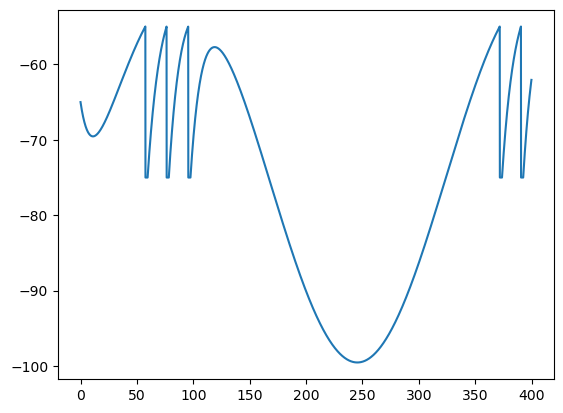

[ 57.5  76.3  95.5 371.8 390.6]


In [5]:
parameters = InitializeParameters()
Voltage = LeakyIntegrate(parameters,'sine',0.02)[0]
Spikes = LeakyIntegrate(parameters,'sine',0.02)[1]

plt.plot(parameters['Timegrid'],Voltage)
plt.show()
print(Spikes)

Indeed, during increasing part of the input current, there is now spiking (as can also be seen from the printed Spike array). Our hypothesis was correct! We can also argue that for a given frequency, one might increase the amplitude of the input current to observe spiking. Lets increase the current to 2500 to see if that happens:

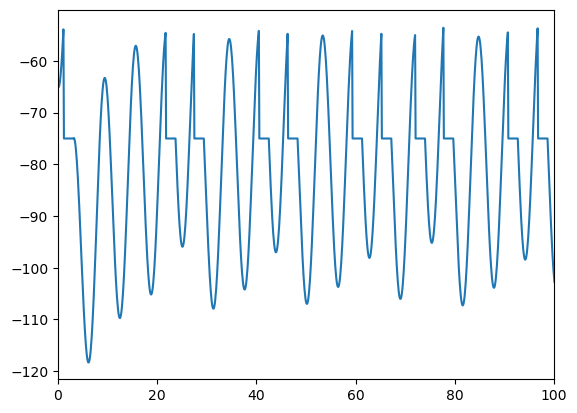

[  1.1  21.7  27.4  40.5  46.3  59.3  65.2  72.   77.7  90.7  96.7 103.3
 109.2 116.  121.6 134.7 140.6 147.4 153.1 166.1 172.1 178.7 184.6 191.4
 197.  210.1 216.  222.8 228.5 241.5 247.5 254.1 260.  266.8 272.4 285.5
 291.4 298.2 303.9 316.9 322.9 329.5 335.4 342.2 347.8 360.9 366.8 373.6
 379.3 392.3 398.3]


In [6]:
parameters = InitializeParameters()
parameters['Current'] = 2500

Voltage = LeakyIntegrate(parameters,'sine')[0]
Spikes = LeakyIntegrate(parameters,'sine')[1]

plt.xlim(0,100)
plt.plot(parameters['Timegrid'],Voltage)
plt.show()
print(Spikes)

And that is indeed what we see! If you don't give the signal enough time to integrate upto the threshold voltage, you have to give it more amplitude to get there in that shorter span of time.

## Running the Leaky Integrate and Fire Model with a Guassian White Noise Input Current:

Using Gaussian White Noise as input for a model gives us valuable insight into how the neuron working under such a model would behave in actual physical situations. This is because the neuron is always receiving noisy input signals from its environment. To generate a Gaussian White Noise input current, we do what we have been doing before: we change our function so as to allow for a currenttype parameter value of "GWN".

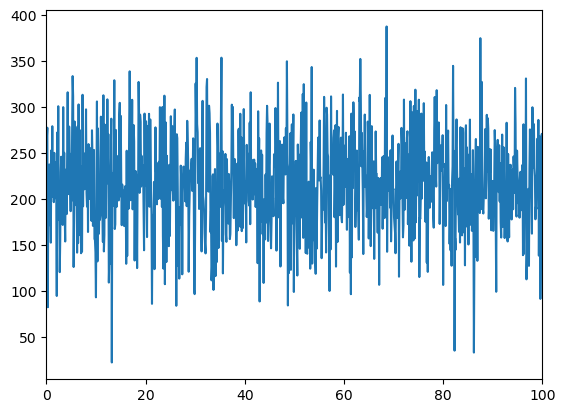

[ 18.4  44.2  69.1  95.5 121.5 150.  176.7 201.9 224.8 252.  275.4 302.3
 327.7 352.8 380.2]


In [85]:
parameters = InitializeParameters()
parameters['Current'] = 220

Voltage = LeakyIntegrate(parameters,'GWN',sig = 0.5)[0]
Spikes = LeakyIntegrate(parameters,'GWN',sig = 0.5)[1]
Current = LeakyIntegrate(parameters,'GWN',sig = 0.5)[2]

plt.xlim(0,100)
plt.plot(parameters['Timegrid'],Current)
plt.show()
print(Spikes)

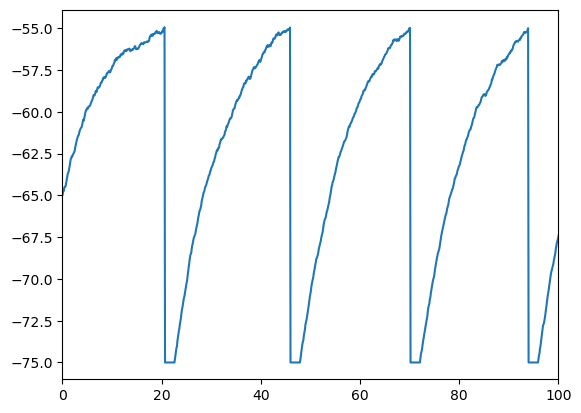

In [86]:
plt.plot(parameters['Timegrid'],Voltage)
plt.xlim(0,100)
plt.show()

## Maximum and Minimum Spiking Frequencies:

After tweaking the value of the input current for some time it was found that the smallest current that generates spikes is actually 200 units. Any constant current with less amplitude than this does not generate spikes. We perturb the current to a value only slightly higher than this and then use the numpy ediff1d function to calculate the time duration between successive spikes in our Spikes array. This comes out to be the same for all of the interspike durations:

[306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9
 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9 306.9
 306.9 306.9 306.9 306.9 306.9 306.9 306.9]


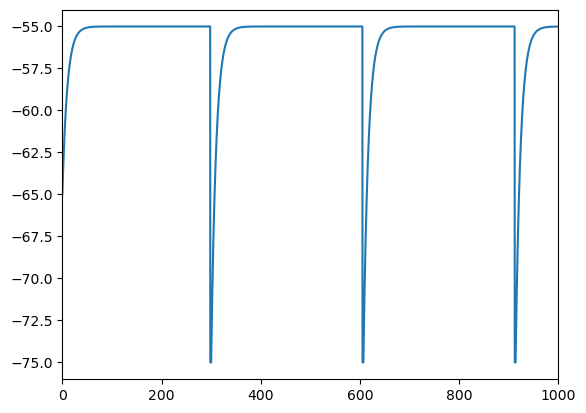

In [7]:
parameters = InitializeParameters()
parameters['Current'] = 200.00000000001
parameters['Duration'] = 10000.
parameters['Timestep'] = 0.1
parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])

Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]


SpikeDistances = np.ediff1d(Spikes)
print(SpikeDistances)
plt.plot(parameters['Timegrid'],Voltage)
plt.xlim(0,1000)
plt.show()

MinSpikingFrequency = 1/np.mean(SpikeDistances)

We can then increase the current to an arbitrarily high value to calculate the maximum spiking frequency as follows:

[2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1
 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1
 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1 2.1]


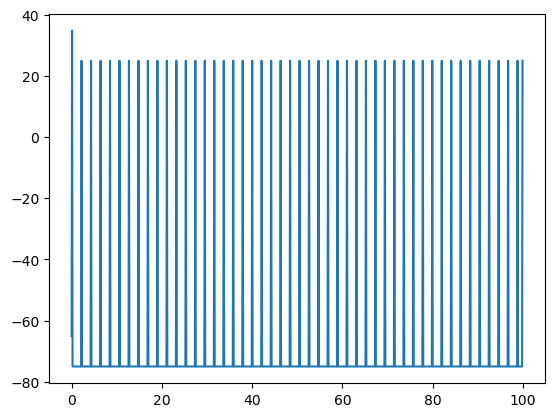

In [116]:
parameters = InitializeParameters()
parameters['Current'] = 100000
parameters['Duration'] = 100.
parameters['Timestep'] = 0.1
parameters['Timegrid'] = np.arange(0, parameters['Duration'], parameters['Timestep'])

Voltage = LeakyIntegrate(parameters,'constant')[0]
Spikes = LeakyIntegrate(parameters,'constant')[1]


SpikeDistances = np.ediff1d(Spikes)
print(SpikeDistances)
plt.plot(parameters['Timegrid'],Voltage)
plt.show()

MaxSpikingFrequency = 1/np.mean(SpikeDistances)
print()

The interspike distances clearly plateau at a value of about 2.1. Any increase in the input current beyond this point has no effect on the output voltage signal. This is because the refractory period prevents the neuron from spiking at arbitrarily high frequencies.

In [9]:
print("The maximum spiking frequency is: " + str(MaxSpikingFrequency) + " per millisecond")
print("The minimum spiking frequency is: " + str(MinSpikingFrequency) + " per millisecond")

The maximum spiking frequency is: 0.47619047619047616 per millisecond
The minimum spiking frequency is: 0.003258390355164549 per millisecond


## Plotting Spiking Frequency against Input Current:

We now run the model for different constant values of the input current and see how the spiking frequency varies.

<function matplotlib.pyplot.show(close=None, block=None)>

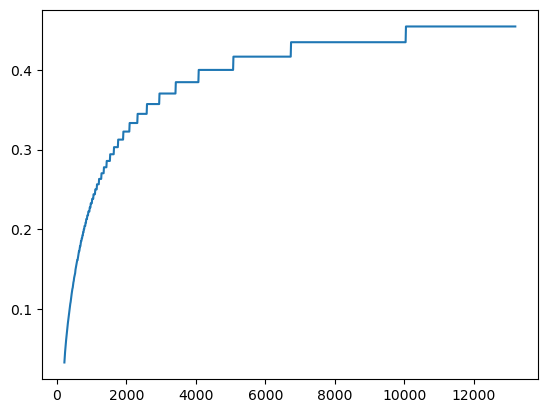

In [37]:
step = 10
Currents = np.zeros(1300)
Frequencies = np.zeros(1300)
parameters['Duration'] = 10
parameters['Current'] = 202

for i in range(1300):
    parameters['Current'] += step
    Voltage = LeakyIntegrate(parameters,'constant')[0]
    Spikes = LeakyIntegrate(parameters,'constant')[1]
    SpikeDistances = np.ediff1d(Spikes)
    SpikingFrequency = 1/SpikeDistances[0]
    Frequencies[i] = SpikingFrequency
    Currents[i] = parameters['Current']
    
plt.plot(Currents,Frequencies)
plt.show

Notice how the spiking frequency increases as we increase the input current until a plateau is reached. The spiking frequency increases in steps, meaning that there is a range of values of the current for which the same spiking frequency is observed until a jump in the spiking frequency takes place. This is due to the discrete nature of the method through which we have inserted spiking into the model.

## Effect of standard deviation of GWN current on the spiking frequency:

We now apply gaussian white noise currents with different standard deviations to our LIF model and notice how the FI curve is affected:

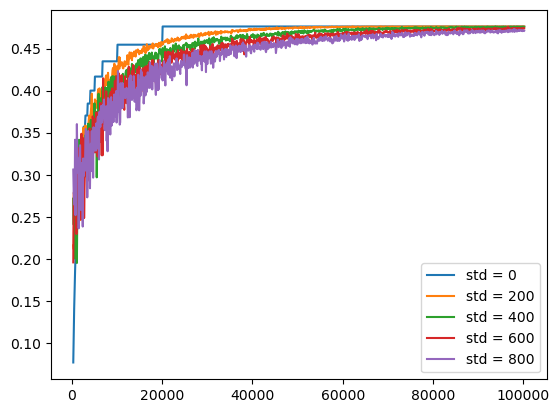

In [114]:
deviations = np.arange(0,1000,200)

for j in range(5):
    step = 100
    Currents = np.zeros(1000)
    Frequencies = np.zeros(1000)
    parameters['Duration'] = 10
    parameters['Current'] = 200

    for i in range(1000):
        parameters['Current'] += step
        Voltage = LeakyIntegrate(parameters,'GWN',sig = deviations[j])[0]
        Spikes = LeakyIntegrate(parameters,'GWN',sig = deviations[j])[1]
        SpikeDistances = np.ediff1d(Spikes)
        SpikingFrequency = 1/np.mean(SpikeDistances)
        Frequencies[i] = SpikingFrequency
        Currents[i] = parameters['Current']
    plt.plot(Currents,Frequencies, label = 'std = ' + str(deviations[j]))

plt.legend()
plt.show()



Evidently, increasing the standard deviation has the effect that the spiking frequency gets saturated at higher values of the mean current. Notice also that since the standard deviation in the noise is being increased, the fluctuations in the frequency of the spikes increases as well.

## Relation between spiking frequency and the coefficient of variation of the GWN current:

The formula for $CV_{ISI}$ is given as:

$$CV_{ISI} = \frac{\text{std}(isi)}{\text{mean}(isi)}$$

### Standard Deviation:

It is evident that increasing the standard deviation of the current increses the coefficient of variation of the interspike intervals. This is precisely because a greater standard deviation for a given mean basically just means that the fluctuations in the current around that mean value are stronger. Since these fluctuations are guassian-random, this means that there are just as many large deviations below the mean as there are above the mean. Consequently, for larger standard deviations, as the LIF is trying to integrate a large positive signal, a large negative incursion immediately afterwards might counter-act it, resulting in less spiking frequency for that particular mean value.

### Mean:

The greater the mean the higher the lower the coefficient of variation in the interspike distances. This is actually quite easy to understand. Since the current fluctuates around the mean, if the mean is higher the output voltage in general fluctuates closer to the threshold voltage. This in turn means that the number/frequency of spikes is larger.

## 2) The Hodgkin-Huxley Model:

The Hodgkin-Huxley model is a relatively computationally expensive model which was developed by Hodgkin Huxley following their experiments on the giant axon of a squid. One of the great advantages of the model is that the spiking behaviour is built into the differential equations, there is nothing that needs to be introduced in an ad-hoc manner. The disadvantage that comes with this is that a number of different variables (known as the gating variables) need to be kept track of, each of which is governed by its own differential equations.

The Hodgkin-Huxley model is governed by the following differential equations:

## Gating variables:

While the gating variables may seem like fitting parameters at first, they provide a great deal of insight as to how the neuron generates an action potential. These gating variables are governed by the following equations: